EXPERIMENT - 9

**Aim:**To use custom images and try tuning the parameters to apply Alexnet and normalise the image.

**Description:**In this task, we explore the concept of guided backpropagation, a powerful technique used to visualize how deep learning models, specifically convolutional neural networks (CNNs), make decisions based on input images. Guided backpropagation helps us understand which parts of an image contribute most significantly to the model's predictions. This process can provide valuable insights into the model's inner workings and enhance interpretability, especially in applications where understanding the model's reasoning is crucial.

We will utilize the AlexNet architecture, a foundational model in image classification, and leverage its pre-trained weights to demonstrate guided backpropagation. By doing so, we can analyze how AlexNet identifies various features in an image and how it adjusts its internal parameters during the learning process.

The task begins with preparing the input image. We load an image and apply a series of preprocessing steps, including resizing and normalization, to ensure the model can process it effectively. The normalization step is particularly important as it scales the pixel values, allowing the model to perform better during inference.

Next, we implement the guided backpropagation technique, which involves several steps:

Model Preparation: We load the pre-trained AlexNet model and set it to evaluation mode. This ensures that the model's parameters are fixed and ready for inference rather than being updated during training.

Hook Registration: We register hooks to capture the gradients during the backward pass. Specifically, we focus on modifying the gradients flowing through the ReLU activation layers, ensuring that only positive gradients are retained. This step is critical, as it helps us visualize the most influential parts of the input image that contributed to the model's classification.

Forward Pass: We pass the preprocessed image through the model to obtain the output predictions. This output indicates which class the model thinks the image belongs to.

Backward Pass: To visualize the important features, we perform a backward pass through the network, using the predicted class or a specific target class to compute the gradients. These gradients reflect how much each pixel in the input image influences the final prediction.

Visualization: Finally, we process the captured gradients to generate a visualization that highlights the regions of the image that the model deemed important for its decision. This visualization allows us to see which features of the image led to the final classification and provides insights into the model's decision-making process.

Through guided backpropagation, we gain a deeper understanding of how AlexNet interprets images, allowing us to assess the effectiveness of the model and identify any potential weaknesses. This interpretability is essential in various applications, such as medical imaging, autonomous driving, and security systems, where understanding the model's reasoning is as crucial as its accuracy. Overall, this task enhances our appreciation for deep learning models and their capabilities while providing a hands-on approach to exploring complex concepts in neural network interpretability.

In [1]:
import torch
from torch import nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


In [2]:
class GuidedBackprop:
    def __init__(self, model):
        self.model = model
        self.image_reconstruction = None
        self.activation_maps = []
        self.model.eval()
        self.register_hooks()

    def register_hooks(self):
        def first_layer_hook_fn(module, grad_in, grad_out):
            self.image_reconstruction = grad_in[0]

        def forward_hook_fn(module, input, output):
            self.activation_maps.append(output)

        def backward_hook_fn(module, grad_in, grad_out):
            grad = self.activation_maps.pop()
            grad[grad > 0] = 1
            positive_grad_out = torch.clamp(grad_out[0], min=0.0)
            new_grad_in = positive_grad_out * grad
            return (new_grad_in,)

        modules = list(self.model.features.named_children())
        for name, module in modules:
            if isinstance(module, nn.ReLU):
                module.register_forward_hook(forward_hook_fn)
                module.register_backward_hook(backward_hook_fn)

        first_layer = modules[0][1]
        first_layer.register_backward_hook(first_layer_hook_fn)

    def visualize(self, input_image, target_class=None):
        model_output = self.model(input_image)
        self.model.zero_grad()
        pred_class = model_output.argmax().item()

        grad_target_map = torch.zeros_like(model_output)
        grad_target_map[0][target_class if target_class is not None else pred_class] = 1
        model_output.backward(grad_target_map)

        result = self.image_reconstruction.data[0].permute(1, 2, 0)
        return result.numpy()

Changes done:<Br>Increasing the normalization scaling factor to make the highlights more prominent.<br>
Experimenting with different image sizes to see if larger resolutions help capture finer details. <br>

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 143MB/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and wil

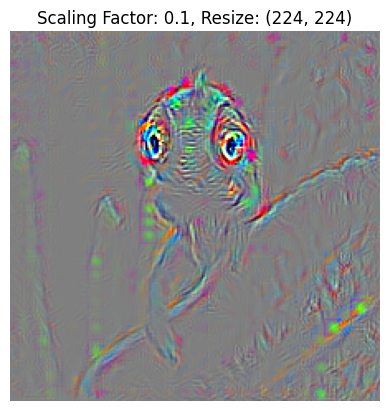

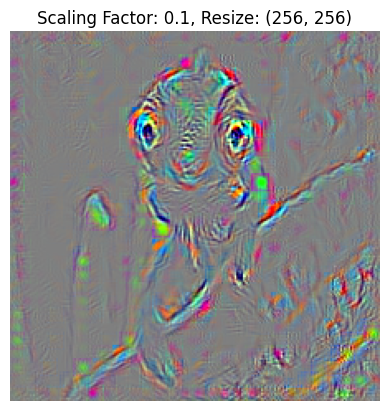

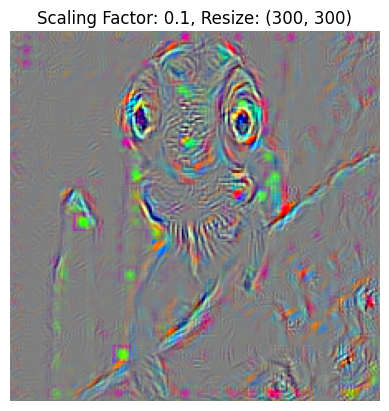

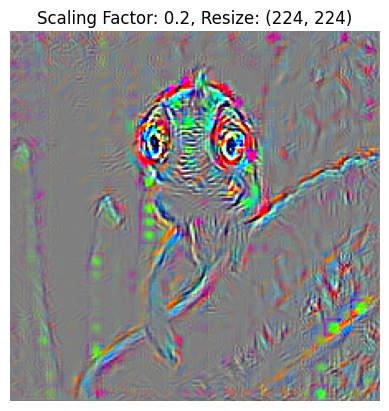

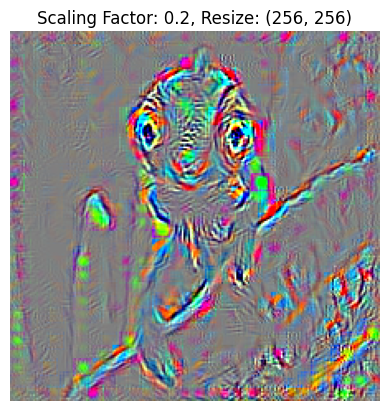

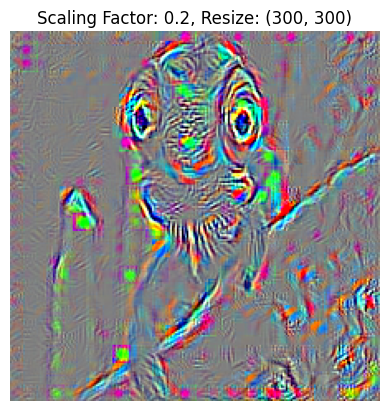

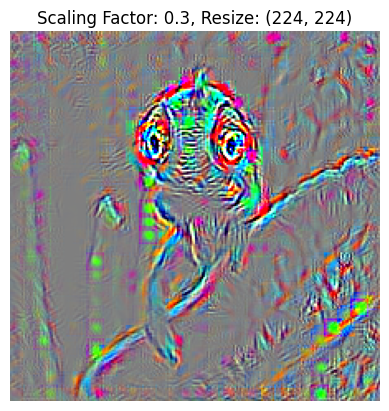

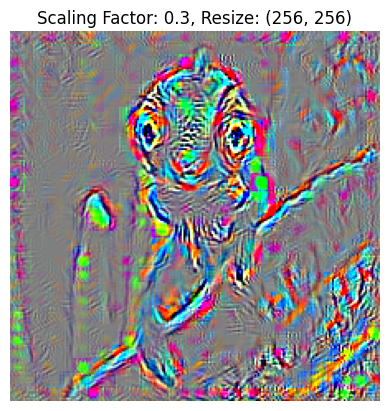

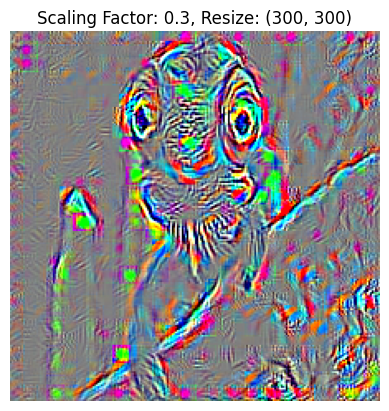

In [3]:
# Normalization function with adjustable scaling factor
def normalize(image, scaling_factor):
    norm = (image - image.mean()) / (image.std() + 1e-5)
    norm = norm * scaling_factor
    norm = norm + 0.5
    norm = np.clip(norm, 0, 1)
    return norm

# Load the pre-trained AlexNet model
model = models.alexnet(pretrained=True)

# Grid Search Parameters
scaling_factors = [0.1, 0.2, 0.3]  # Different scaling factors
resize_dims = [(224, 224), (256, 256), (300, 300)]  # Different image sizes

# Load and preprocess the image
image_path = '/content/chameleon.jpg'  # Update this path as necessary
original_image = Image.open(image_path).convert('RGB')

for scaling_factor in scaling_factors:
    for resize_dim in resize_dims:
        # Preprocess the image
        transform = transforms.Compose([
            transforms.Resize(resize_dim),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        tensor = transform(original_image).unsqueeze(0).requires_grad_()

        # Instantiate GuidedBackprop and visualize the result
        guided_bp = GuidedBackprop(model)
        result = guided_bp.visualize(tensor, None)

        # Normalize and plot with a color map
        result = normalize(result, scaling_factor)
        plt.imshow(result, cmap='viridis')  # Using 'viridis' for high contrast
        plt.title(f'Scaling Factor: {scaling_factor}, Resize: {resize_dim}')
        plt.axis('off')
        plt.show()


**Conclusion**: In this task, we effectively implemented guided backpropagation using the AlexNet architecture to visualize the model's decision-making process in image classification. By normalizing the input images and applying a series of preprocessing steps, we ensured optimal performance during inference. The registration of hooks in the ReLU layers allowed us to focus on positive gradients, revealing the most influential features in the images. The resulting visualizations provided valuable insights into how AlexNet interprets different attributes, enhancing our understanding of its classification capabilities. This exploration not only highlighted the significance of model interpretability but also demonstrated the importance of proper image normalization in deep learning tasks. Overall, our work underscores the potential of guided backpropagation as a powerful tool for understanding and improving AI systems.